# XGBoost
***
XGBoost is a python framework that allows us to train Boosted Trees while expoiting multicore parallelism. 
## Regression
***
Boosted Trees are used for regression. 
## Gradient Boosted Trees
***
Boosted trees are similar to random forests - an amalgamation of decision trees. In a regression forest, you predict the average of the labels for each of the leaves. 
## Boosted Trees vs Random Forest
***
For a boosted tree, we change the labels every time we add a new tree. For each new tree, we update labels by subtracting the sum of the previous tree's predictions, multiplied by a certain learning rate. In this way, each tree learns by correcting the mistakes of previous trees. 

In the prediction phase, it returns the sum of the predictions of all of the trees, multiplied by the learning rate. So, unlike random forests or bagged trees, this model will overfit if we increase the quantity of trees.

# The Data
***
We are going to be using the Human Development Index, which contains information about the development level of countries over multiple metrics for long periods of time. 

Our data contains a column for every year and a row for each country and metric, so we need to do some preprocessing. 

Right away, upon hearing that we have a column for each year, I know we are going to have to do a ```pd.melt```, because that is not "tidy" data. In other words, when you have several different values of a variable represented in its own column, it is usually helpful to collapse those columns into a single one, labeled by year. 

In [16]:
import pandas as pd
import xgboost as xgb
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

In [17]:
data = pd.read_csv('2018_all_indicators.csv')
print(data.shape)
data.head()

(25636, 34)


,dimension,indicator_id,indicator_name,iso3,country_name,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,9999
0,Composite indices,146206,HDI rank,AFG,Afghanistan,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,168.0,NaN
1,Composite indices,146206,HDI rank,ALB,Albania,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.0,68.0,NaN
2,Composite indices,146206,HDI rank,DZA,Algeria,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.0,85.0,NaN
3,Composite indices,146206,HDI rank,AND,Andorra,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,35.0,NaN
4,Composite indices,146206,HDI rank,AGO,Angola,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.0,147.0,NaN


Here are the indicators we have:

In [18]:
data.loc[:,'indicator_name'].unique()

array(['HDI rank', 'Human Development Index (HDI)', 'Median age (years)',
       'Old-age (65 and older) dependency ratio (per 100 people ages 15-64)',
       'Population ages 15–64 (millions)',
       'Population ages 65 and older (millions)',
       'Population under age 5 (millions)',
       'Sex ratio at birth (male to female births)',
       'Total population (millions)', 'Urban population (%)',
       'Young age (0-14) dependency ratio (per 100 people ages 15-64)',
       'Education index', 'Expected years of schooling (years)',
       'Expected years of schooling, female (years)',
       'Expected years of schooling, male (years)',
       'Government expenditure on education (% of GDP)',
       'Gross enrolment ratio, pre-primary (% of preschool-age children)',
       'Gross enrolment ratio, primary (% of primary school-age population)',
       'Gross enrolment ratio, secondary (% of secondary school-age population)',
       'Gross enrolment ratio, tertiary (% of tertiary school

Get the labels:

In [19]:
y = data[data['indicator_name']=='Life expectancy at birth (years)'].loc[:,'2017']

Get the features:

I want a new DataFrame where the row labels are the country code, and the new columns I see are expanded from ```indicator_name```. Then, I select the year 2017 to use to predict the life expectancy at birth. 

The original result of the pivot table resulted in a MultiIndex in the columns, using both the years and the unique values contained in ```indicator_name```

In [20]:
X_2017 = pd.pivot_table(data,index=['iso3'],columns=['indicator_name'])['2017']

When I tried to drop null values, I wound up with a DataFrame with zero entries. This is because there are so many features, and the dataset is largely incomplete, so every single country had at least one of the features missing. Therefore, I need to take a smalelr subset of the descriptors and then drop null values to get a useful dataframe

In [21]:
descriptors = ['Expected years of schooling (years)', 'Expected years of schooling, female (years)',
              'Expected years of schooling, male (years)', 'Infants lacking immunization, measles (% of one-year-olds)',
              'Life expectancy at birth (years)' , 'Share of seats in parliament (% held by women)',
              'Unemployment, total (% of labour force)','Unemployment, youth (% ages 15–24)',
              'Vulnerable employment (% of total employment)','Youth unemployment rate (female to male ratio)']
X_2017_subset = X_2017.loc[:,descriptors]
X_2017_subset_no_null = X_2017_subset.dropna()
X_2017_subset_no_null.count()

indicator_name
Expected years of schooling (years)                           170
Expected years of schooling, female (years)                   170
Expected years of schooling, male (years)                     170
Infants lacking immunization, measles (% of one-year-olds)    170
Life expectancy at birth (years)                              170
Share of seats in parliament (% held by women)                170
Unemployment, total (% of labour force)                       170
Unemployment, youth (% ages 15–24)                            170
Vulnerable employment (% of total employment)                 170
Youth unemployment rate (female to male ratio)                170
dtype: int64

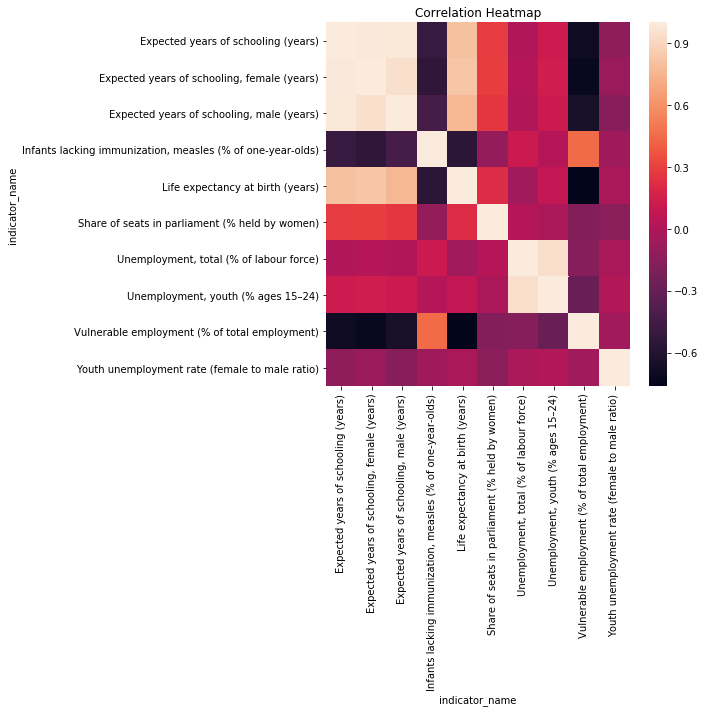

In [22]:
fig = sns.heatmap( X_2017_subset_no_null.corr() )
plt.title("Correlation Heatmap")
plt.tight_layout()

Here we see that life expectancy at birth is highly correlated with vaccination, vulenrable employment and education. 

We would expect these features to be the ones that our model relies most heavily on. XGBoost supplies us with a feature importance method so we can see which of the columns was most informative. 

This explainability that boosted trees have gives a huge edge over neural networks.

In [23]:
from sklearn.model_selection import train_test_split
# create a mask to separate labels from features
mask = X_2017_subset_no_null.columns == 'Life expectancy at birth (years)'

# select the features by inverting the mask
X = X_2017_subset_no_null.loc[:,~mask]
# select the labels by using the mask
y = X_2017_subset_no_null.loc[:,mask]
# split into train and test sets with a 80-20 split
x_train, x_test, y_train, y_test = train_test_split( X , y ,  test_size=0.2 )

The ```xgboost.DMatrix``` is an internal data structure used by XGBoost that is optimized for memory efficiency and training speed. The constructor for a ```DMatrix``` from a DataFrame is as below:

# Training the XGBoost Model
***

In [42]:
# create training set 
dtrain = xgb.DMatrix( x_train , label=y_train )
# create test set
dtest = xgb.DMatrix( x_test , label=y_test )

# hyperparameters
param = { 'max_depth':6,
        'learning_rate':1,
        'colsample_bytree':1,
         'nthread':4
        }

num_round = 15

# do the training with 15 epochs!
initial_trees = xgb.train( param , dtrain , num_round )

[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[20:43:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_d

In [25]:
# now we make predictions on the new data set to see how we did
predictions = initial_trees.predict( dtest )
print(predictions)

[77.52817  58.091866 72.130714 65.87883  72.09056  52.88012  76.96407
 69.61014  78.57157  60.549717 65.974144 81.28013  82.17648  77.09117
 71.48125  74.96486  69.001205 75.89222  60.865505 73.03947  76.82783
 58.15168  73.88932  59.34299  77.23712  59.91564  73.00879  68.21533
 79.950714 75.835754 75.23261  82.048965 81.49809  81.74559 ]


In [26]:
from sklearn.metrics import mean_squared_error

# compute L2 loss
loss = np.sqrt(mean_squared_error( y_test , predictions ))
print(loss)

4.650254306327226


Hmmmm, that wasn't very good. let's try again with more epochs

In [47]:
num_round = 40

# do the training with 15 epochs!
initial_trees_second_try = xgb.train( param , dtrain , num_round )

[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=6
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[20:43:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_d

In [51]:
# now we make predictions on the new data set to see how we did
predictions2 = initial_trees.predict( dtest )
print(predictions2)
loss2 = np.sqrt(mean_squared_error( y_test , predictions2 ))
print("Average Error (years): ", loss2)

[77.52817  58.091866 72.130714 65.87883  72.09056  52.88012  76.96407
 69.61014  78.57157  60.549717 65.974144 81.28013  82.17648  77.09117
 71.48125  74.96486  69.001205 75.89222  60.865505 73.03947  76.82783
 58.15168  73.88932  59.34299  77.23712  59.91564  73.00879  68.21533
 79.950714 75.835754 75.23261  82.048965 81.49809  81.74559 ]
Average Error (years):  4.650254306327226


In [53]:
X_2017_subset_no_null.describe()

indicator_name,Expected years of schooling (years),"Expected years of schooling, female (years)","Expected years of schooling, male (years)","Infants lacking immunization, measles (% of one-year-olds)",Life expectancy at birth (years),Share of seats in parliament (% held by women),"Unemployment, total (% of labour force)","Unemployment, youth (% ages 15–24)",Vulnerable employment (% of total employment),Youth unemployment rate (female to male ratio)
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,13.268824,13.354706,13.201765,12.200000,72.163529,22.183529,7.658824,17.146471,36.347647,1.096353
std,3.010165,3.416789,2.687765,13.650151,7.697211,11.137865,5.800332,12.400268,26.135317,0.206417
min,4.900000,3.800000,5.800000,1.000000,52.200000,0.100000,0.200000,0.400000,0.200000,0.630000
25%,11.400000,11.100000,11.800000,3.000000,66.800000,13.775000,4.025000,8.325000,12.300000,0.980000
50%,13.300000,13.650000,13.150000,7.000000,73.800000,20.150000,5.900000,13.650000,31.600000,1.070000
75%,15.200000,15.775000,14.900000,15.750000,77.400000,29.975000,9.700000,23.250000,55.550000,1.180000
max,22.900000,23.300000,22.500000,80.000000,83.900000,55.700000,27.700000,57.400000,92.400000,2.500000


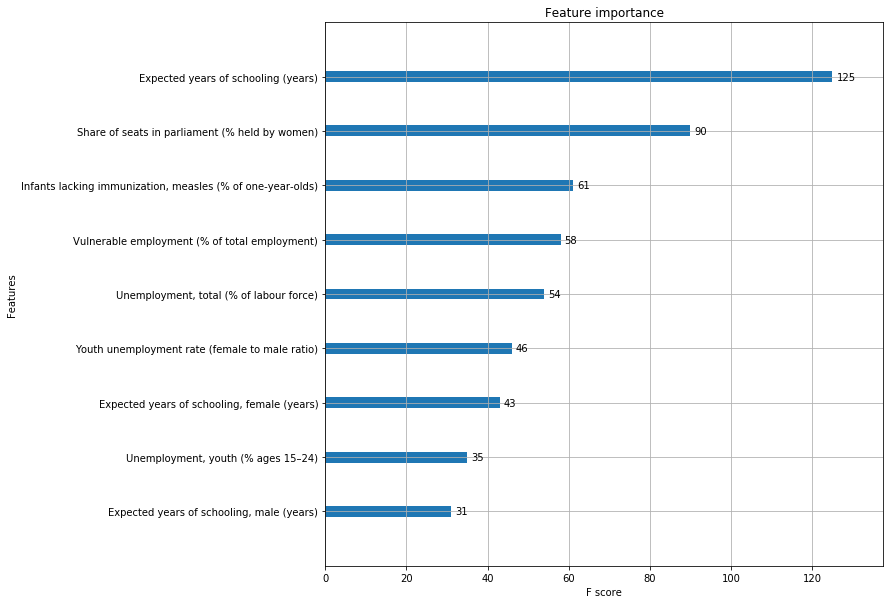

In [52]:
xgb.plot_importance(initial_trees_second_try)
plt.show()

So we saw the average error was about 4 and a half years. This is not too terrible, considering the standard deviation for the life expectancy was 7.69 years.

In addition, we see that our initial thoughts from the correlation plot are actually supported by the decisions made on this data. 

# Conclusions
***
This toy model gave us a relatively good regression model, and helped us confirm our suspicions about the most decisive factors in life expectancy. Also, training this model was extremely fast, especially since you can specify a number of threads to run in parallel. 